# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from mne.stats import fdr_correction
from scipy.stats import mannwhitneyu, pearsonr, spearmanr
from LabUtils.HigherLevelRanksum import directed_mannwhitneyu
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, r2_score
from statsmodels.regression.linear_model import OLS


curr_dir = mkdirifnotexists(os.path.join('metabolomics_model_of_bmi'))

In [3]:
learning_rate = [0.1, 0.05, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.002, 0.001, 0.0005, 0.0001]
num_leaves = range(2, 35)
max_depth = [-1, 2, 3, 4, 5, 10, 20, 40, 50]
min_data_in_leaf = range(1, 45, 2)
feature_fraction = [i / 10. for i in range(2, 11)]  # [1] when using dummy variables
metric = ['l2']
early_stopping_rounds = [None]
# early_stopping_rounds = [10, 20, 50]
num_threads = [1]
verbose = [-1]
silent = [True]
n_estimators = range(100, 500, 50)
bagging_fraction = [i / 10. for i in range(2, 11)]
bagging_freq = [0, 1, 2]
lambda_l1 = [0, 0.001, 0.005, 0.01, 0.1]

# Lasso params
alpha = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]


lightgbm_rscv_space = {'learning_rate': learning_rate, 'max_depth': max_depth,
                       'feature_fraction': feature_fraction, 'num_leaves': num_leaves,
                       'min_data_in_leaf': min_data_in_leaf, 'metric': metric,
                       'early_stopping_rounds': early_stopping_rounds, 'n_estimators': n_estimators,
                       'bagging_fraction': bagging_fraction, 'bagging_freq': bagging_freq,
                       'num_threads': num_threads, 'verbose': verbose, 'silent': silent, 'lambda_l1': lambda_l1}

# Load data

In [4]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
# pnp_data = pnp_data[pnp_data.IsGenotek == 0]
acs_data['ACS sample'], pnp_data['ACS sample'] = 1, 0

pnp_data.index = pnp_data.index.astype(str)
acs_data.index = acs_data.index.astype(str)

Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
updated_metabs1 = pd.read_csv('additional_metabolon_files/updated_metabs1.csv', index_col=0)
circ_heatmap_df_sorted = pd.read_csv(os.path.join('serum_metabolomics_signatures/', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)

In [7]:
acs_data['combined_outcome'] = acs_data[['Acute MI', 'Acute stroke', 'Acute limb event', 'Unplanned PCI', 'New-onset HF', 'New-onset Afib', 'CV hospitalization including chest pain', 'CV death',]].any(1)
acs_data['Acute_MI_or_Stroke'] = acs_data[['Acute MI', 'Acute stroke']].any(1)
acs_data['Number of vessels involved: 1 vs 3'] = acs_data['Number of vessels involved'].replace({1:0, 3:1, 2:np.nan})
acs_data['Number of vessels involved: 1 vs 2,3'] = acs_data['Number of vessels involved'].replace({1:0, 3:1, 2:1})
acs_data['Number of vessels involved: 1,2 vs 3'] = acs_data['Number of vessels involved'].replace({1:0, 3:1, 2:0})
acs_data['combined_cvd_outcome'] = acs_data[['Acute MI', 'Acute stroke', 'Unplanned PCI', 'CV death',]].any(1)

## metabolon

In [9]:
storage_bad_metabs = pd.read_pickle(os.path.join('data', 'storage_time_bad_metabs_bonf.pkl'))

In [10]:
metabolon_molecules_to_remove = storage_bad_metabs

In [11]:
print(len(metabolon_molecules_to_remove))

25


## nightingale

In [12]:
nightingale_metabolites = pd.read_csv(os.path.join('data', 'nightingale_metabolite_metadata.csv'), index_col=0)
nightingale_metabolites

,Biomarker name,Excel column name,Group,Subgroup,Unit,nightingale_run,nightingale_run_id
markers,,,,,,,
Acetate,Acetate,Acetate,Ketone bodies,NaN,mmol/l,Nightingale_Sep2019,0
Acetoacetate,Acetoacetate,Acetoacetate,Ketone bodies,NaN,mmol/l,Nightingale_Sep2019,0
Ala,Alanine,Ala,Amino acids,NaN,mmol/l,Nightingale_Sep2019,0
Albumin,Albumin,Albumin,Fluid balance,NaN,signal area,Nightingale_Sep2019,0
ApoA1,Apolipoprotein A1,ApoA1,Apolipoproteins,NaN,g/l,Nightingale_Sep2019,0
...,...,...,...,...,...,...,...
XXL_VLDL_PL,Phospholipids in chylomicrons and extremely la...,XXL-VLDL-PL,Lipoprotein subclasses,Chylomicrons and extremely large VLDL,mmol/l,Nightingale_Sep2019,0
XXL_VLDL_PL_pct,Phospholipids to total lipids ratio in chylomi...,XXL-VLDL-PL %,Relative lipoprotein lipid concentrations,Chylomicrons and extremely large VLDL ratios,%,Nightingale_Sep2019,0
XXL_VLDL_TG,Triglycerides in chylomicrons and extremely la...,XXL-VLDL-TG,Lipoprotein subclasses,Chylomicrons and extremely large VLDL,mmol/l,Nightingale_Sep2019,0


## merge data

In [40]:
pnp_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data/', 'pnp_data_metabolon_storage_residuals.csv'))
pnp_data_metabolon['RegistrationCode'] = pnp_data_metabolon['RegistrationCode'].astype(str)
pnp_data_metabolon.set_index(['RegistrationCode'], inplace=True)

acs_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data/', 'acs_data_metabolon_storage_residuals.csv'))
acs_data_metabolon['RegistrationCode'] = acs_data_metabolon['RegistrationCode'].astype(str)
acs_data_metabolon.set_index(['RegistrationCode'], inplace=True)

data = pd.concat((pnp_data_metabolon, pnp_data.loc[~pnp_data.index.isin(pnp_data_metabolon.index)], acs_data_metabolon), axis=0, sort=False)#.sort_index()
print (data.shape)
data = data.reindex(nightingale_metabolites.index.tolist() + metabolon.df.columns.tolist() + ['Age', 'gender', 'bmi', 'ACS sample'], axis=1).dropna(how='all', axis=1).dropna(how='all', axis=0)
print (data.shape)

Columns (43,3236) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (1,11,24,31,41,97,108,111,112,113,132,133,134,135,136,137,138,139,140,141,142,143,144,146,149,150,151,152,153,154,156,158,160,170,171,180,185,3213) have mixed types.Specify dtype option on import or set low_memory=False.


(1187, 4684)
(1187, 1193)


# Predictive models

In [18]:
healthy_real_bmi = data[data['ACS sample'] == 0]['bmi']
healthy_pred_age_sex_bmi = pd.DataFrame(np.nan, index=data[data['ACS sample'] == 0].index, columns=['bmi'])

acs_real_bmi = data[data['ACS sample'] == 1]['bmi']
acs_pred_age_sex_bmi = pd.DataFrame(0, index=data[data['ACS sample'] == 1].index, columns=['bmi'])

y_bmi = healthy_real_bmi.dropna().copy()

## GBDT

In [19]:
mkdirifnotexists(os.path.join(curr_dir, 'GBDT'))

'/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v3/metabolomics_model_of_bmi/GBDT'

In [20]:
import shap
print ('shap', shap.__version__)
import sklearn
print ('sklearn', sklearn.__version__)

shap 0.35.0
sklearn 0.24.2


### train-test

In [21]:
gbdt_dir = mkdirifnotexists(os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine'))

In [22]:
nightingale_molecules_to_remove = ['Albumin', 'Glucose', 'Creatinine', 'TAG_Creatinine']

In [24]:
gbdt_dir = mkdirifnotexists(os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine'))
# in each fold learn on the 4/5 healthy and predict the fold of healthy, and add age predictions to the acs as well.
models, healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict, acs_Xs, healthy_Xs, healthy_shap_values_dic, acs_shap_values_dic = {}, {}, {}, {}, {}, {}, {}

for data_name, data_cols in zip(['metabolon', 'nightingale'], 
                                [metabolon.df.columns.tolist(), nightingale_metabolites.index.tolist()]):
#     if data_name != 'metabolon':
#         break
    print (data_name)
    temp_data = data.reindex(data_cols + ['ACS sample'], axis=1).dropna(how='all', axis=1).copy()
    temp_data = temp_data.loc[temp_data.notnull().sum(1)>temp_data.shape[1]/2, :]
    mkdirifnotexists(os.path.join(gbdt_dir, data_name))
    X_healthy = temp_data.loc[temp_data[temp_data['ACS sample'] == 0].index].reindex(data_cols, axis=1).dropna(how='all', axis=1).copy()
    X_tag = add_null_indicator_column(X_healthy, null='TAG', fillna=0, prefix='TAG').astype(float)
#     X_not_null = add_null_indicator_column(X_tag, fillna=0, prefix='null')
    X_not_null = X_tag

    X_acs = temp_data.loc[temp_data[temp_data['ACS sample'] == 1].index].reindex(data_cols, axis=1).dropna(how='all', axis=1).copy()
    X_acs_tag = add_null_indicator_column(X_acs, null='TAG', fillna=0, prefix='TAG').astype(float)
#     X_acs_not_null = add_null_indicator_column(X_acs_tag, fillna=0, prefix='null')
    X_acs_not_null = X_acs_tag

    X_not_null = pd.concat((X_not_null, X_acs_not_null), axis=0).fillna(0).loc[X_not_null.index]
    X_acs_not_null = pd.concat((X_not_null, X_acs_not_null), axis=0).fillna(0).loc[X_acs_not_null.index]

    acs_pred_age_sex_bmi.loc[:, :] = np.nan
    healthy_pred_age_sex_bmi.loc[:, :] = np.nan
    
    temp_X = X_not_null.copy()
    temp_X_acs = X_acs_not_null.copy()
    if 'metabolon' in data_name:
        temp_X = temp_X.drop(metabolon_molecules_to_remove, axis=1)
        temp_X_acs = temp_X_acs.drop(metabolon_molecules_to_remove, axis=1).copy()
#         continue
    if 'nightingale' in data_name:
        temp_X = temp_X.drop(nightingale_molecules_to_remove, axis=1)
        temp_X_acs = temp_X_acs.drop(nightingale_molecules_to_remove, axis=1).copy()
        
    print ('healthy X', temp_X.shape, 'ACS X', temp_X_acs.shape)
    acs_Xs[data_name] = temp_X_acs.copy()
    healthy_Xs[data_name] = {}
    
    healthy_shap_values_dic[data_name] = {}
    acs_shap_values_dic[data_name] = {}
    
    models[data_name] = {}

    for target, X, y, mode in zip(['bmi'], 
                                  [temp_X.merge(y_bmi, on='RegistrationCode').drop('bmi', axis=1)],
                                  [temp_X.merge(y_bmi, on='RegistrationCode')['bmi']],
                                  ['cont']):
        healthy_Xs[data_name][target] = X.copy()
        
        acs_shap_values_dic[data_name][target] = pd.DataFrame(0, index=temp_X_acs.index, columns=temp_X_acs.columns)
        print (target, mode, X.shape)

        train_idx, test_idx = train_test_split(X.index, test_size=temp_X_acs.shape[0], random_state=0)
        X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
        print ('train-test shapes:', X_train.shape, X_test.shape)
        healthy_shap_values_dic[data_name][target] = pd.DataFrame(np.nan, index=X_test.index, columns=X_test.columns)

        if mode == 'cont':
            model = lgb.LGBMRegressor()
            rscv = RandomizedSearchCV(model, lightgbm_rscv_space, n_iter=5, cv=3, random_state=0)
            rscv.fit(X_train, y_train)

            y_pred = rscv.best_estimator_.predict(X_test)
            healthy_pred_age_sex_bmi.loc[X_test.index, target] = y_pred

            y_pred = rscv.best_estimator_.predict(temp_X_acs)
            acs_pred_age_sex_bmi.loc[temp_X_acs.index, target] = y_pred

            explainer = shap.TreeExplainer(rscv.best_estimator_)
            try:
                # changed on 3.10.2018, last column is the bias column
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)
            except:
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)[:, :-1]
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)[:, :-1]

    
    healthy_pred_age_sex_bmi.to_csv(os.path.join(gbdt_dir, data_name, 'healthy_pred_bmi.csv'))
    acs_pred_age_sex_bmi = acs_pred_age_sex_bmi.replace(0, np.nan)
    acs_pred_age_sex_bmi.to_csv(os.path.join(gbdt_dir, data_name, 'acs_pred_bmi.csv'))
    healthy_pred_age_sex_bmi_dict[data_name] = healthy_pred_age_sex_bmi.copy()
    acs_pred_age_sex_bmi_dict[data_name] = acs_pred_age_sex_bmi.copy()
with open(os.path.join(gbdt_dir, 'models.pkl'), 'wb') as handle:
    pickle.dump(models, handle)
with open(os.path.join(gbdt_dir, 'acs_Xs.pkl'), 'wb') as handle:
    pickle.dump(acs_Xs, handle)
with open(os.path.join(gbdt_dir, 'healthy_Xs.pkl'), 'wb') as handle:
    pickle.dump(healthy_Xs, handle)
with open(os.path.join(gbdt_dir, 'acs_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(acs_shap_values_dic, handle)
with open(os.path.join(gbdt_dir, 'healthy_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(healthy_shap_values_dic, handle)

metabolon
healthy X (473, 936) ACS X (156, 936)
bmi cont (453, 936)
train-test shapes: (297, 936) (156, 936)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

nightingale
healthy X (954, 229) ACS X (179, 229)
bmi cont (926, 229)
train-test shapes: (747, 229) (179, 229)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

In [25]:
gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine')
healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict = {}, {}
for d in ['metabolon', 'nightingale']:
    healthy_pred_age_sex_bmi_dict[d] = pd.read_csv(os.path.join(gbdt_dir, d, 'healthy_pred_bmi.csv'), index_col=0)
    acs_pred_age_sex_bmi_dict[d] = pd.read_csv(os.path.join(gbdt_dir, d, 'acs_pred_bmi.csv'), index_col=0)
with open(os.path.join(gbdt_dir, 'acs_shap_values_dic.pkl'), 'rb') as handle:
    acs_shap_values_dic = pickle.load(handle)
with open(os.path.join(gbdt_dir, 'healthy_shap_values_dic.pkl'), 'rb') as handle:
    healthy_shap_values_dic = pickle.load(handle)

In [26]:
acs_shap_values_dic['metabolon']['bmi'].to_csv(os.path.join(gbdt_dir, 'metabolon', 'acs_shap_values_dic_metabolon_bmi.csv'))

metabolon


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


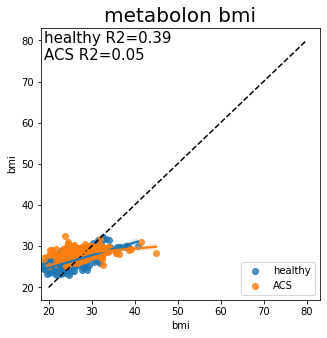

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


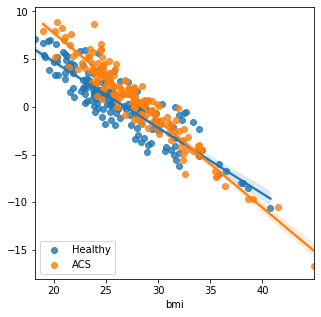

nightingale


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


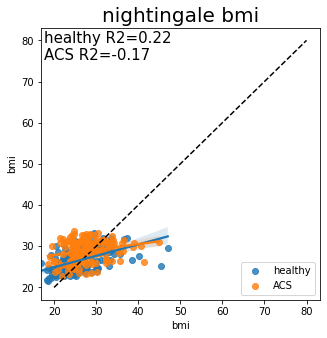

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


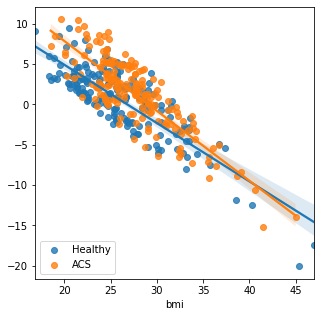

In [27]:
for data_name in healthy_pred_age_sex_bmi_dict:
    print (data_name)
    for target, healthy_y, acs_y in zip(['bmi'], [healthy_real_bmi], [acs_real_bmi]):
        healthy_r2 = r2_score_rmna(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target])
        acs_r2 = r2_score_rmna(acs_y, acs_pred_age_sex_bmi_dict[data_name][target])
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot([20, 80], [20, 80], '--', color='black')
        sns.regplot(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target], label='healthy')
        sns.regplot(acs_y, acs_pred_age_sex_bmi_dict[data_name][target], label='ACS')
        add_text_at_corner(ax, 'healthy R2=%0.2f\nACS R2=%0.2f'%(healthy_r2, acs_r2), 'top left', fontsize=15)
        ax.set_title(data_name + ' ' + target, fontsize=20)
        ax.legend(loc='lower right')
        plt.show()
        
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        healthy_diffs = healthy_pred_age_sex_bmi_dict[data_name][target].values - healthy_y.values
        acs_diffs = acs_pred_age_sex_bmi_dict[data_name][target].values - acs_y.values
        sns.regplot(healthy_y, healthy_diffs, label='Healthy')
        sns.regplot(acs_y, acs_diffs, label='ACS')
        ax.legend(loc='lower left')
        plt.show()

#### correlate diffs with clinical params

In [41]:
acs_real_bmi - acs_pred_age_sex_bmi_dict['metabolon']['bmi'].reindex(acs_real_bmi.index)
acs_bmi_diffs = pd.Series(acs_pred_age_sex_bmi_dict['metabolon']['bmi'].values - acs_real_bmi.values, index=acs_real_bmi.index, name='acs bmi diffs')
acs_data.loc[acs_bmi_diffs.index, 'acs bmi diffs'] = acs_bmi_diffs.values
acs_data['const'] = 1
c = 'Number of vessels involved: 1 vs 3'
spearmanr(acs_data.loc[acs_bmi_diffs.index, c], acs_bmi_diffs, nan_policy='omit')

SpearmanrResult(correlation=0.06852186353056682, pvalue=0.4831186904582848)

In [29]:
spearmanr(acs_data['Glucose Disorder: DM2'], acs_data['Number of vessels involved'], nan_policy='omit')

SpearmanrResult(correlation=0.1416569840442442, pvalue=0.04486310615710625)

In [30]:
ps = acs_shap_values_dic['metabolon']['bmi'].apply(lambda x: OLS(acs_bmi_diffs.loc[x.index], 
                                                                 pd.concat((acs_data.reindex(x.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().pvalues.loc[x.name])
rs = acs_shap_values_dic['metabolon']['bmi'].apply(lambda x: OLS(acs_bmi_diffs.loc[x.index], 
                                                                 pd.concat((acs_data.reindex(x.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().params.loc[x.name])
rs.dropna().sort_values().head(30)

X - 23294   -945.959145
100001083   -677.365768
100006184   -540.452454
100001992   -516.444023
100001211   -498.216005
100000936   -485.052109
100009162   -465.976259
100008991   -437.557253
X - 12193   -346.958361
827         -322.663294
439         -306.999266
100004208   -303.176684
100001208   -267.402085
100001198   -240.249315
X - 12100   -192.301353
100001182   -183.741104
100009394   -179.324095
100001987   -160.064307
229         -156.009741
535         -154.322255
X - 12753   -152.874489
100001541   -149.277230
892         -147.827870
100001295   -142.472008
1231        -139.017092
X - 12680   -135.124235
100001181   -132.635766
100009336   -130.942666
100003686   -129.643619
240         -129.120309
dtype: float64

In [371]:
fdr_correction(ps.dropna(), alpha=0.01)[0].sum()#.sort_values().head(20)

60

# Plot

In [32]:
def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

In [42]:
logit_data = acs_data.dropna(subset=['acs bmi diffs']).copy()
covariates = ['bmi', 'const', 'Age', 'Glucose Disorder: DM2']
col = 'acs bmi diffs'
use_covariates = True
ys = ['Number of vessels involved: 1 vs 3', 'Known CAD', 
      'Number of vessels involved: 1 vs 2,3', 'Number of vessels involved: 1,2 vs 3', 'combined_cvd_outcome']
logit_data['const'] = 1

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=ys, columns=columns)

for y in ys:
    if covariates:
        try:
            log = Logit(logit_data[y].astype(float),
                        logit_data.reindex([col] + covariates, axis=1), missing='drop').fit(disp=0)
            logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
    
covariates = ['bmi', 'const', 'Age']
ys = ['Glucose Disorder: DM2']

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']

for y in ys:
    if covariates:
        try:
            log = Logit(logit_data[y].astype(float), 
                        logit_data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
logit_results = logit_results.dropna()
logit_results

,coef,pval,0.025,0.975,log
Number of vessels involved: 1 vs 3,1.503684,0.034214,1.030821,2.193461,<statsmodels.discrete.discrete_model.BinaryRes...
Known CAD,0.939066,0.673169,0.701174,1.257671,<statsmodels.discrete.discrete_model.BinaryRes...
"Number of vessels involved: 1 vs 2,3",1.304449,0.068593,0.979937,1.736426,<statsmodels.discrete.discrete_model.BinaryRes...
"Number of vessels involved: 1,2 vs 3",1.452655,0.029589,1.037695,2.033553,<statsmodels.discrete.discrete_model.BinaryRes...
combined_cvd_outcome,0.782357,0.282911,0.499852,1.224526,<statsmodels.discrete.discrete_model.BinaryRes...
Glucose Disorder: DM2,1.478919,0.013023,1.085941,2.014108,<statsmodels.discrete.discrete_model.BinaryRes...


In [35]:
print ('ACS real-predicted pearson', pearsonr_rmna(acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']))
print ('Healthy real-predicted pearson', pearsonr_rmna(healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']))

ACS real-predicted pearson (0.2864073667099917, 0.0002893063472816646)
Healthy real-predicted pearson (0.6679755666750811, 1.6520494938463235e-21)


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


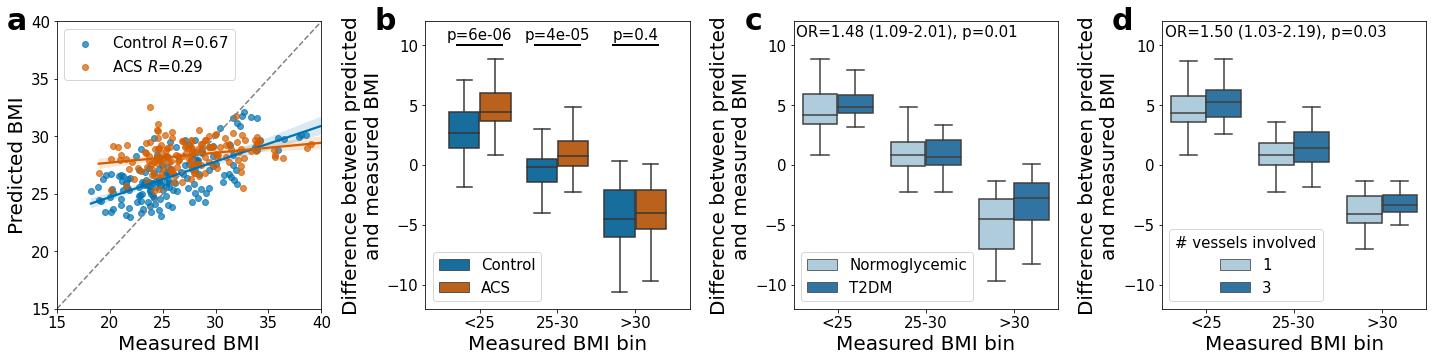

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'



age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Control %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=healthy_real_bmi.index.tolist() + acs_real_bmi.index.tolist(), columns=['x', 'y', 'z'])
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].values - healthy_real_bmi.values
df.loc[healthy_real_bmi.index, 'x'] = y.values
df.loc[healthy_real_bmi.index, 'y'] = yy
df.loc[healthy_real_bmi.index, 'z'] = 'Control'
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon'].loc[:, 'bmi'].values - acs_real_bmi.values
df.loc[acs_real_bmi.index, 'x'] = y.values
df.loc[acs_real_bmi.index, 'y'] = yy
df.loc[acs_real_bmi.index, 'z'] = 'ACS'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
bmi_diff_bins = df.dropna().sort_values('x').copy()
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[healthy_color, acs_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-12, 12))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'Control') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'ACS') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 10.5,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=10, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')

ax = axes[2]
c = 'Glucose Disorder: DM2'
logit_data['bmi bin'] = pd.cut(logit_data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bmi bin', y='acs bmi diffs', data=logit_data.sort_values('bmi').replace({c:{0:'Normoglycemic', 1:'T2DM'}}), ax=ax, palette=colors, hue=c, showfliers=False)
ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='')
leg.get_title().set_fontsize(str(tick_fontsize))
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.set_ylim((-12, 12))
add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)    
    
ax = axes[3]
c = 'Number of vessels involved: 1 vs 3'
logit_data['bmi bin'] = pd.cut(logit_data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bmi bin', y='acs bmi diffs', data=logit_data.sort_values('bmi').replace({c:{0:'1', 1:'3'}}), ax=ax, palette=colors, hue=c, showfliers=False)
ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='# vessels involved')
leg.get_title().set_fontsize(str(tick_fontsize))
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.set_ylim((-12, 12))
add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)


fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'd', ha='center', va='center', transform=axes[3].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(gbdt_dir, 'Figure4.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'Figure4.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(gbdt_dir, 'Figure4.png'), dpi=1000, bbox_inches='tight')

In [94]:
bmi_diff_bins.groupby(['z', 'bin']).mean()

x         y
z       bin                       
ACS     25-30  27.380931  1.255492
        <25    23.255760  5.083593
        >30    33.322315 -3.644934
Control 25-30  27.277164 -0.410500
        <25    22.629178  2.318622
        >30    33.890557 -4.646209

## supp table - shap drivers

In [64]:
ps = acs_shap_values_dic['metabolon']['bmi'].apply(lambda x: OLS(acs_bmi_diffs.loc[x.index], 
                                                                 pd.concat((acs_data.reindex(x.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().pvalues.loc[x.name])
rs = acs_shap_values_dic['metabolon']['bmi'].apply(lambda x: OLS(acs_bmi_diffs.loc[x.index], 
                                                                 pd.concat((acs_data.reindex(x.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().params.loc[x.name])
fdr_correction(ps.dropna(), alpha=0.01)[0].sum()

60

In [67]:
df = pd.concat((ps.sort_values().dropna().rename('SHAP-delta BMI pvalue'), rs.rename('SHAP-delta BMI coef'), circ_heatmap_df_sorted,
          pnp_data_metabolon.loc[:, ps.sort_values().dropna().index]\
                .apply(lambda x: spearmanr(x, pnp_data_metabolon['bmi'], nan_policy='omit')[0]).rename('metabolite-BMI in healthy cohort Spearman rho'),
          acs_data_metabolon.loc[logit_data.index, ps.sort_values().dropna().index]\
                .apply(lambda x: spearmanr(x, logit_data['Glucose Disorder: DM2'], nan_policy='omit')[0]).rename('metabolite-Glucose Disorder: DM2 Spearman rho'),
          acs_data_metabolon.loc[logit_data.index, ps.sort_values().dropna().index]\
                .apply(lambda x: spearmanr(x, logit_data['Glucose Disorder: DM2'], nan_policy='omit')[1]).rename('metabolite-Glucose Disorder: DM2 Spearman pvalue'),   
          acs_data_metabolon.loc[logit_data.index, ps.sort_values().dropna().index]\
                .apply(lambda x: spearmanr(x, logit_data['Number of vessels involved: 1 vs 3'], nan_policy='omit')[0]).rename('metabolite-Number of vessels involved: 1, 3 Spearman rho'),
          acs_data_metabolon.loc[logit_data.index, ps.sort_values().dropna().index]\
                .apply(lambda x: spearmanr(x, logit_data['Number of vessels involved: 1 vs 3'], nan_policy='omit')[1]).rename('metabolite-Number of vessels involved: 1, 3 Spearman pvalue'), 
          acs_data_metabolon.loc[logit_data.index, ps.sort_values().dropna().index]\
                .apply(lambda x: mannwhitneyu(x.loc[logit_data[logit_data['Number of vessels involved: 1 vs 3']==0].index].dropna(), 
                                              x.loc[logit_data[logit_data['Number of vessels involved: 1 vs 3']==1].index].dropna())[1]).rename('metabolite-Number of vessels involved: 1, 3 MWU pvalue')),
          axis=1).dropna().rename_axis('CHEMICAL_ID')
df['SHAP-delta BMI qvalue'] = fdr_correction(df['SHAP-delta BMI pvalue'])[1]
df[df['SHAP-delta BMI qvalue']<0.01].to_csv(os.path.join(gbdt_dir, 'Supplementary_table_metabolon_bmi_shap_drivers.csv'))

In [75]:
df[df['SHAP-delta BMI qvalue']<0.01]

,SHAP-delta BMI pvalue,SHAP-delta BMI coef,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,metabolite-BMI in healthy cohort Spearman rho,metabolite-Glucose Disorder: DM2 Spearman rho,metabolite-Glucose Disorder: DM2 Spearman pvalue,"metabolite-Number of vessels involved: 1, 3 Spearman rho","metabolite-Number of vessels involved: 1, 3 Spearman pvalue","metabolite-Number of vessels involved: 1, 3 MWU pvalue",SHAP-delta BMI qvalue
CHEMICAL_ID,,,,,,,,,,,,,,,
100015968,7.766831e-11,1.925444,-6.657476,-0.542305,0.013476,0.106296,0.069322,0.000000,-0.249435,-0.033581,0.678282,-0.138005,0.156320,0.156323,6.710542e-08
1242,4.112800e-09,4.552066,5.472279,0.078138,0.000000,0.000827,0.110953,0.000000,0.311741,0.033259,0.681192,0.015369,0.875147,0.876868,1.776730e-06
X - 12026,7.409196e-09,14.636268,-0.350871,-0.865136,0.000000,0.028845,0.207825,0.000000,0.350477,-0.044452,0.582855,0.167142,0.085296,0.085881,2.133848e-06
279,4.236003e-08,3.121683,6.636945,0.157084,0.034636,0.053464,0.238511,0.000000,0.346309,0.037417,0.643919,0.293299,0.002169,0.002558,9.149767e-06
100001051,5.354714e-08,-103.307904,-0.223940,-0.030627,0.060132,0.147267,0.219240,0.000000,0.181263,-0.033899,0.675404,0.057635,0.555411,0.555127,9.252946e-06
100001412,6.948897e-08,3.968641,0.549432,-0.018572,0.000000,0.066599,0.114038,0.000000,0.357438,0.060442,0.455007,0.287536,0.002673,0.003106,1.000641e-05
100001977,1.782183e-07,7.885565,-0.383417,-1.017525,0.054541,0.300000,0.079566,0.000000,-0.246209,-0.151586,0.059721,-0.034581,0.723628,0.724285,2.199722e-05
100009009,2.258156e-07,11.933556,0.053610,-1.947881,0.006287,0.018604,0.132500,0.000000,-0.373603,-0.183246,0.022472,-0.218373,0.023841,0.024768,2.438808e-05
381,1.030150e-06,14.643319,-5.957068,0.204851,0.072423,0.119250,0.229474,0.000000,0.343191,0.064768,0.423321,0.165244,0.088956,0.089510,8.976025e-05


In [71]:
df.loc[['100001395', '100009009', '100009007', '100002462']]

,SHAP-delta BMI pvalue,SHAP-delta BMI coef,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,metabolite-BMI in healthy cohort Spearman rho,metabolite-Glucose Disorder: DM2 Spearman rho,metabolite-Glucose Disorder: DM2 Spearman pvalue,"metabolite-Number of vessels involved: 1, 3 Spearman rho","metabolite-Number of vessels involved: 1, 3 Spearman pvalue","metabolite-Number of vessels involved: 1, 3 MWU pvalue",SHAP-delta BMI qvalue
CHEMICAL_ID,,,,,,,,,,,,,,,
100001395,1.343420e-05,6.487826,-9.528168,-1.118011,0.000000,0.060318,0.078544,0.0,-0.293519,-0.103296,0.200884,-0.205566,0.033657,0.034590,0.000553
100009009,2.258156e-07,11.933556,0.053610,-1.947881,0.006287,0.018604,0.132500,0.0,-0.373603,-0.183246,0.022472,-0.218373,0.023841,0.024768,0.000024
100009007,7.964789e-06,7.868906,-0.303066,-3.347978,0.039652,0.063258,0.223122,0.0,-0.411206,-0.255201,0.001352,-0.115270,0.237084,0.236617,0.000362
100002462,1.531777e-05,17.821215,1.760835,0.292319,0.000000,0.025448,0.167884,0.0,0.337588,0.006076,0.940185,0.229900,0.017211,0.018095,0.000571


In [72]:
updated_metabs1.loc[['100001395', '100009009', '100009007', '100002462']] # 100001395, 100009009

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
CHEMICAL_ID,,,,,,,,,,,,,,,
100001395,34419,HMDB10386,NaN,1-linoleoyl-GPC (18:2),NaN,10160888.0,C04100,520.33977,1947.0,LC/MS Pos Late,11988421.0,1465.0,Lysophospholipid,Lipid,1-linoleoyl-GPC (18:2)
100009009,52682,HMDB11211,NaN,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...,NaN,24767486.0,NaN,742.57452,2132.0,LC/MS Pos Late,NaN,2226.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...
100009007,52478,NaN,NaN,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,NaN,NaN,NaN,744.59017,2125.0,LC/MS Pos Late,NaN,2443.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*
100002462,43582,NaN,NaN,5-(galactosylhydroxy)-L-lysine,32448-36-5,NaN,NaN,325.16055,93.0,LC/MS Pos Early,NaN,2755.0,Lysine Metabolism,Amino Acid,5-(galactosylhydroxy)-L-lysine


In [806]:
updated_metabs1.loc[['100009009', '100001395', '100002462']]

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
CHEMICAL_ID,,,,,,,,,,,,,,,
100009009,52682,HMDB11211,NaN,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...,NaN,24767486.0,NaN,742.57452,2132.0,LC/MS Pos Late,NaN,2226.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...
100001395,34419,HMDB10386,NaN,1-linoleoyl-GPC (18:2),NaN,10160888.0,C04100,520.33977,1947.0,LC/MS Pos Late,11988421.0,1465.0,Lysophospholipid,Lipid,1-linoleoyl-GPC (18:2)
100002462,43582,NaN,NaN,5-(galactosylhydroxy)-L-lysine,32448-36-5,NaN,NaN,325.16055,93.0,LC/MS Pos Early,NaN,2755.0,Lysine Metabolism,Amino Acid,5-(galactosylhydroxy)-L-lysine


In [74]:
(df['SHAP-delta BMI qvalue']<0.01).sum()

59

## replication using nightingale data

In [85]:
acs_data.loc[acs_bmi_diffs.index, 'nightingale acs bmi diffs'] = pd.Series(acs_pred_age_sex_bmi_dict['nightingale']['bmi'].values - acs_real_bmi.values, index=acs_real_bmi.index, 
                                                                           name='nightingale acs bmi diffs').values


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


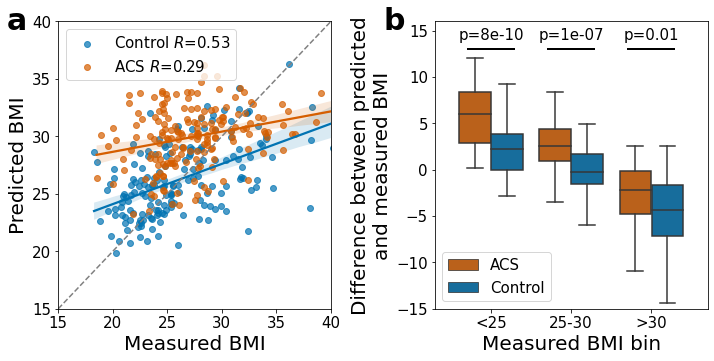

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['nightingale']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Control %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['nightingale']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=healthy_real_bmi.index.tolist() + acs_real_bmi.index.tolist(), columns=['x', 'y', 'z'])
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['nightingale']['bmi'].values - healthy_real_bmi.values
df.loc[healthy_real_bmi.index, 'x'] = y.values
df.loc[healthy_real_bmi.index, 'y'] = yy
df.loc[healthy_real_bmi.index, 'z'] = 'Control'
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['nightingale'].loc[:, 'bmi'].values - acs_real_bmi.values
df.loc[acs_real_bmi.index, 'x'] = y.values
df.loc[acs_real_bmi.index, 'y'] = yy
df.loc[acs_real_bmi.index, 'z'] = 'ACS'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
df = df.sort_values(['z', 'bin'])
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[acs_color, healthy_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-15, 16))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'Control') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'ACS') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 14,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=13, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')

fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_Nightingale_a-b.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_Nightingale_a-b.pdf'), dpi=300, bbox_inches='tight')